In [1]:
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import dataholders as dh
import utils

In [3]:
path = 'data_flight16.mat'
window = 501
data = dh.TempWindData(path, path, True)

#data.cut_time(*flat1)

#data.get_angles(True)
#data.get_temp_from_voltage()
#data.get_temp_deviations(window)
#data.get_angle_deviations(window)

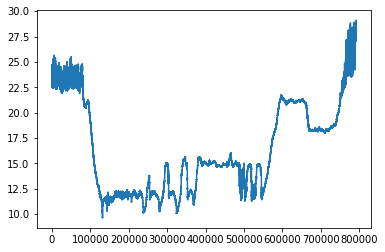

In [4]:
plt.plot(data.T1)

plt.show()

In [5]:
part1 = ( 885,  900)
part2 = (4505, 4520)
part3 = (6385, 6400)
part4 = (6540, 6555)
part5 = (7170, 7185)

parts = [part1, part2, part3, part4, part5]

In [6]:
part1 = ( 885,  900)
part2 = (4505, 4520)
part3 = (6385, 6400)
#part4 = (6540, 6555)
part5 = (7170, 7185)

parts = [part1, part2, part3, part5]

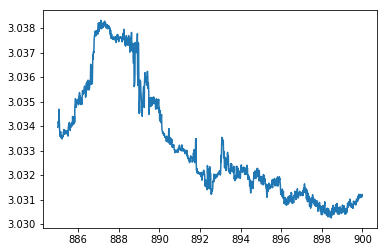

In [7]:
plt.plot(utils.array_range(data.time, *part1), utils.array_range(data.V1, *part1, ref=data.time))
plt.show()

# To do:

Write a convenient .mat file manager #

Re-generate the data_flight16.mat file

Make sure synchronize() works (!!!)

Do the analysis

__Rethink sync__

In [9]:
data = loadmat('data_flight16.mat')

In [10]:
time_uft = data['time_av'].ravel()
V1 = data['lowV_av'].ravel()
V2 = data['upV_av'].ravel()

uft_vars = [V1, V2]

In [12]:
T_virtual = data['sonicT'].ravel()
water1 = data['licorH2O'].ravel()
water2 = data['dp1AH'].ravel()
T_ref1 = data['sonicPRT'].ravel()
T_ref2 = data['hmpT'].ravel()

T_ref3 = T_virtual / (1 + 0.61 * water1 * 1e-3)
T_ref4 = T_virtual / (1 + 0.61 * water2 * 1e-3)

time_actos = np.arange(T_virtual.shape[0]) / 100. #data['time'].ravel()


actos_vars = [T_virtual, T_ref1, T_ref2, T_ref3, T_ref4]

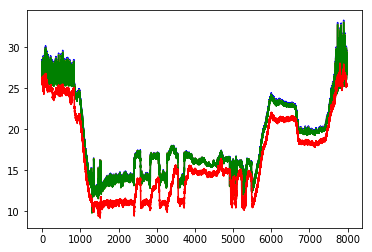

In [13]:
plt.plot(time_actos, T_virtual, 'b')
plt.plot(time_actos, T_ref3, 'orange')
plt.plot(time_actos, T_ref4, 'g')
plt.plot(time_actos, T_ref1, 'r')
plt.show()

In [14]:
def synchronize(time1, time2, arrays1, arrays2):
        low = np.max((time1[0], time2[0]))
        
        time1 -= (time1[time1 >= low][0] - time2[time2 >= low][0])
        
        high = np.min((time1[-1], time2[-1])) + 1e-9
        new_arrays1 = []
        new_arrays2 = []
        
        new_arrays2 = list(map(lambda x: utils.array_range(x, low, high, time2), arrays2))
        new_arrays1 = list(map(lambda x: utils.array_range(x, low, high, time1), arrays1))
        
        time2 = utils.array_range(time2, low, high, time2)
            
        time1 = utils.array_range(time1, low, high, time1)

        return time1, new_arrays1, new_arrays2

In [15]:
def synchronize_(time1, time2, array1, array2):
        """Synchronizes the wind and temperature data."""
        low = np.max((time1[0], time2[0]))
        time1 -= (time1[time1 >= low][0] - time2[time2 >= low][0])

        high = np.min((time1[-1], time2[-1])) + 1e-9  # Includes a small constant to keep the same shape

        array2 = utils.array_range(array2, low, high, time2)

        
        time2 = utils.array_range(time2, low, high, time2)

        array1 = utils.array_range(array1, low, high, time1)

        time1 = utils.array_range(time1, low, high, time1)
        
        time = time2
        
        return time, array1, array2

In [16]:
time, uft_sync, actos_sync = synchronize(time_uft, time_actos, uft_vars, actos_vars)

In [17]:
[V1, V2] = uft_sync

In [18]:
[T_virtual, T_ref1, T_ref2, T_ref3, T_ref4] = actos_sync

In [19]:
V1_parts = list(map(
    lambda x: np.mean(utils.array_range(V1, *x, time)),
    parts
))

V2_parts = list(map(
    lambda x: np.mean(utils.array_range(V2, *x, time)),
    parts
))

T_ref1_parts = list(map(
    lambda x: np.mean(utils.array_range(T_ref1, *x, time)),
    parts
))

T_ref2_parts = list(map(
    lambda x: np.mean(utils.array_range(T_ref2, *x, time)),
    parts
))

T_ref3_parts = list(map(
    lambda x: np.mean(utils.array_range(T_ref3, *x, time)),
    parts
))

T_ref4_parts = list(map(
    lambda x: np.mean(utils.array_range(T_ref4, *x, time)),
    parts
))

T_virtual_parts = list(map(
    lambda x: np.mean(utils.array_range(T_virtual, *x, time)),
    parts
))

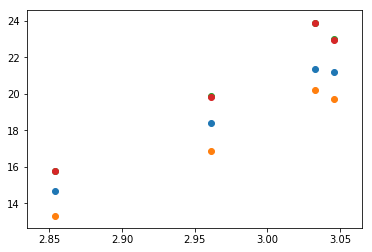

In [29]:
plt.scatter(V1_parts, T_ref1_parts)
plt.scatter(V1_parts, T_ref2_parts)
plt.scatter(V1_parts, T_ref3_parts)
plt.scatter(V1_parts, T_ref4_parts)
#plt.scatter(V1_parts, T_virtual_parts)

plt.show()

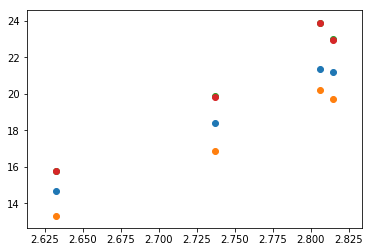

In [25]:
plt.scatter(V2_parts, T_ref1_parts)
plt.scatter(V2_parts, T_ref2_parts)
plt.scatter(V2_parts, T_ref3_parts)
plt.scatter(V2_parts, T_ref4_parts)
#plt.scatter(V2_parts, T_virtual_parts)

plt.show()

In [22]:
T_ref2_parts

[20.217392551142012, 13.300000000000001, 19.699999999999996, 16.87633729079085]

In [24]:
V1_parts

[3.0331981546990012,
 2.8540750397549974,
 3.0456399593618979,
 2.9614196089515032]

In [30]:
def get_coef(x1, y1, x2, y2):
    return (y2 - y1) / (x2 - x1)

def get_coefs(Xs, Ys):
    assert len(Xs) == len(Ys)
    
    res = []
    for i in range(len(Xs)-1):
        res.append(get_coef(Xs[i], Ys[i], Xs[i+1], Ys[i+1]))
    return res

In [31]:
get_coefs(V1_parts, T_virtual_parts)

[46.015245983828912, 38.262390891966881, 37.399934443621106]

In [32]:
get_coefs(V2_parts, T_virtual_parts)

[47.444925488108368, 40.225224778064522, 40.769583704859457]

In [33]:
get_coefs(V1_parts, T_ref1_parts)

[37.321742805433637, 34.233521318921603, 33.293763800688119]

In [34]:
get_coefs(V2_parts, T_ref1_parts)

[38.481317846533479, 35.989677014339286, 36.293456400790198]

In [35]:
get_coefs(V1_parts, T_ref2_parts)

[38.618089872457155, 33.409039677687716, 33.52708336464773]

In [36]:
get_coefs(V2_parts, T_ref2_parts)

[39.817942017211024, 35.122900041680644, 36.54779752823714]

In [37]:
get_coefs(V1_parts, T_ref3_parts)

[45.200937876147371, 37.525898359775709, 37.053986733019435]

In [38]:
get_coefs(V2_parts, T_ref3_parts)

[46.605317078606639, 39.450950694189231, 40.392466890225982]

In [42]:
get_coefs(V1_parts, T_ref4_parts)

[45.109983211655681, 37.453137879334072, 37.004869532517588]

In [39]:
get_coefs(V2_parts, T_ref4_parts)

[46.511536480734343, 39.374457652000928, 40.338924341368653]

Zrobić kalibrację globalną tylko według drugiego dopasowania (37.45..., 39.37...), między punktem 2 a 3

SonicT + licor

In [59]:
path = 'data_flight16.mat'
window = 501
data = dh.TempWindData(path, path, True)

data.cut_time(1000, 1100)

#data.get_angles(True)
data.get_temp_from_voltage()
#data.get_temp_deviations(window)
#data.get_angle_deviations(window)

In [10]:
time_uft = data['time_av'].ravel()
V1 = data['lowV_av'].ravel()
V2 = data['upV_av'].ravel()

uft_vars = [V1, V2]

In [12]:
T_virtual = data['sonicT'].ravel()
water1 = data['licorH2O'].ravel()
water2 = data['dp1AH'].ravel()
T_ref1 = data['sonicPRT'].ravel()
T_ref2 = data['hmpT'].ravel()

T_ref3 = T_virtual / (1 + 0.61 * water1 * 1e-3)
T_ref4 = T_virtual / (1 + 0.61 * water2 * 1e-3)

time_actos = np.arange(T_virtual.shape[0]) / 100. #data['time'].ravel()


actos_vars = [T_virtual, T_ref1, T_ref2, T_ref3, T_ref4]

In [60]:
data.V1

array([ 3.02881262,  3.02902951,  3.02937949, ...,  2.9066621 ,
        2.90653969,  2.90658898])

In [103]:
X = utils.array_range(uft_sync[1], 1000, 1100, time)

In [104]:
Y = utils.array_range(actos_sync[3], 1000, 1100, time)

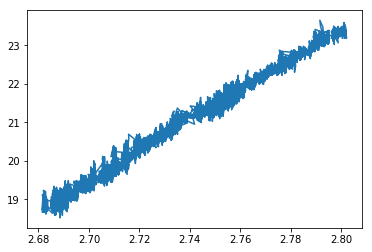

In [105]:
plt.plot(X, Y)
plt.show()

In [106]:
curve_fit(lambda x, a, b: a*x + b, X, Y)[0]

array([ 39.46275591, -87.06986632])

In [107]:
X = utils.array_range(uft_sync[0], 5750, 5950, time)

In [108]:
Y = utils.array_range(actos_sync[3], 5750, 5950, time)

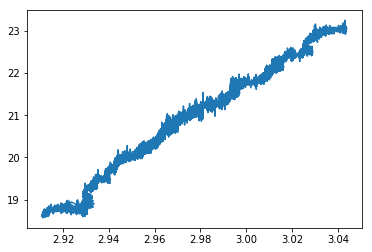

In [109]:
plt.plot(X, Y)
plt.show()

In [110]:
curve_fit(lambda x, a, b: a*x + b, X, Y)[0]

array([ 35.30264271, -84.15711961])

In [100]:
X = utils.array_range(uft_sync[0], 6700, 7500, time)

Y = utils.array_range(actos_sync[3], 6700, 7500, time)

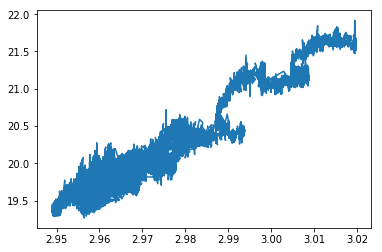

In [101]:
plt.plot(X, Y)
plt.show()

In [102]:
curve_fit(lambda x, a, b: a*x + b, X, Y)[0]

array([ 32.55059709, -76.61794688])

To samo dla pozostałych termometrów, czyli:

na "ładnych" fragmentach dopasowanie na długich odcinkach, porównać z tamtymi dopasowaniami dwupunktowymi

usystematyzować, opisać, zacząć raport

Raport:

problemy w kalibracji

pokazanie kawałków ze skokami etc.

że trzeba klasyfikować

informacja o programie w node